In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

import dataset
import numbs
import tree_search
import backprop
import lpbackprop
import jump_backprop
import constraints
import utils

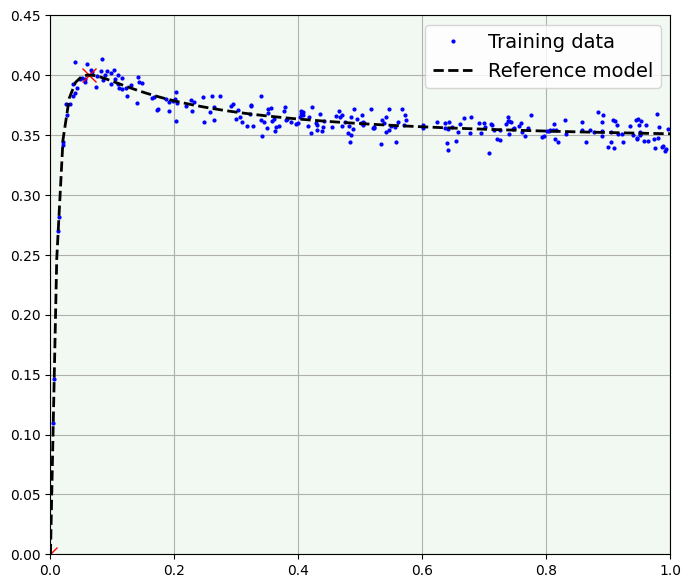

In [2]:
S = dataset.ABSDataset()
S.sample(size=250, noise=0.03, mesh=False)
#S.load('../data/magman.csv')
S.plot(width=8, height=7)

"""new_data = []
for dp in S.data:
    if dp.x < 0 and dp.y > 0 or \
       dp.x > 0 and dp.y < 0: new_data.append(dp)
S.data = new_data"""

S.index()
numbs.init(S)

In [3]:
unknown_stree_a = backprop.UnknownSyntaxTree('A')
unknown_stree_b = backprop.UnknownSyntaxTree('B')
stree     = backprop.BinaryOperatorSyntaxTree('/', unknown_stree_a, unknown_stree_b)
stree_pr  = stree.diff().simplify()
stree_pr2 = stree_pr.diff().simplify()
print(str(stree))
print(str(stree_pr))
print(str(stree_pr2))

(A(x) / B(x))
(((A'(x) * B(x)) - (A(x) * B'(x))) / (B(x) ^ 2))
((((((A''(x) * B(x)) + (A'(x) * B'(x))) - ((A'(x) * B'(x)) + (A(x) * B''(x)))) * (B(x) ^ 2)) - (((A'(x) * B(x)) - (A(x) * B'(x))) * ((2 * B(x)) * B'(x)))) / (B(x) ^ 4))


In [4]:
hist_set = []
best_unkn_models = {}
best_k_mse = None
best_r2 = None

def onsynth_callback(synth_unkn_models:dict):
    global hist_set
    global best_unkn_models
    global best_k_mse
    global best_r2
    
    print('--- On Synth ---')
    for unkn in synth_unkn_models.keys():
        unkn_model, unkn_model_d1, coeffs_mask, constrs = synth_unkn_models[unkn]
        print(f"{unkn}(x) =\n{unkn_model}")
    print()

    hist, __best_unkn_models, __best_r2, __best_k_mse = jump_backprop.jump_backprop(stree, stree_pr, synth_unkn_models, S, max_rounds=1)
    hist_set.append(hist)

    if best_k_mse is None or utils.compare_fit(__best_k_mse, __best_r2, best_k_mse, best_r2):
        best_unkn_models = __best_unkn_models
        best_k_mse = __best_k_mse
        best_r2 = __best_r2

lpbackprop.lpbackprop(S.knowledge, stree, onsynth_callback)

bin_tree_node("m","/","A","B").
unkn_tree_node("A").
deriv("A","A'").
unkn_tree_node("B").
deriv("B","B'").
bin_tree_node("m'","/","m1","m2").
bin_tree_node("m1","-","m3","m4").
bin_tree_node("m3","*","A'","B").
unkn_tree_node("A'").
deriv("A'","A''").
unkn_tree_node("B").
deriv("B","B'").
bin_tree_node("m4","*","A","B'").
unkn_tree_node("A").
deriv("A","A'").
unkn_tree_node("B'").
deriv("B'","B''").
bin_tree_node("m2","^","B",2).
unkn_tree_node("B").
deriv("B","B'").
const_tree_node(2).
const(2).
bin_tree_node("m''","/","m5","m6").
bin_tree_node("m5","-","m7","m8").
bin_tree_node("m7","*","m9","m10").
bin_tree_node("m9","-","m11","m12").
bin_tree_node("m11","+","m13","m14").
bin_tree_node("m13","*","A''","B").
unkn_tree_node("A''").
deriv("A''","A'''").
unkn_tree_node("B").
deriv("B","B'").
bin_tree_node("m14","*","A'","B'").
unkn_tree_node("A'").
deriv("A'","A''").
unkn_tree_node("B'").
deriv("B'","B''").
bin_tree_node("m12","+","m15","m16").
bin_tree_node("m15","*","A'","B'").
unkn_

--- Best Syntax Tree ---
K-MSE: 0.46449028823960115
R2:    0.5662264893373681


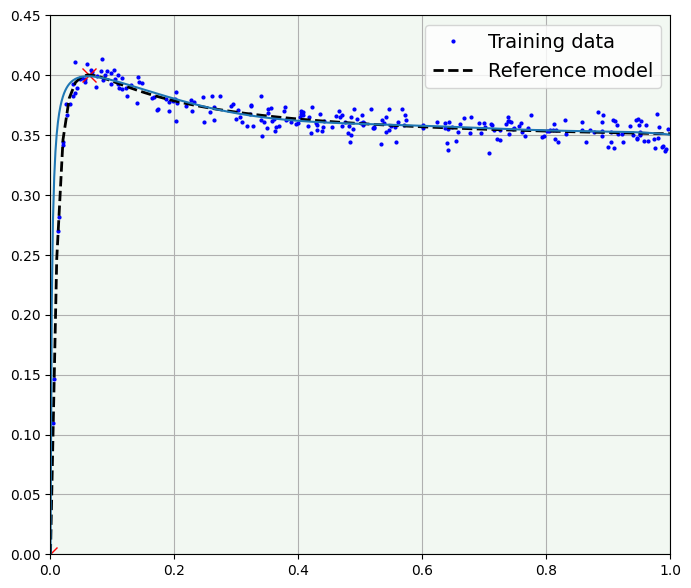

In [5]:
##
## set all synth_unkn_models.
##
#for model_name in synth_unkn_models_set[0].keys():
#    stree.set_unknown_model(model_name, *synth_unkn_models_set[0][model_name])

#
# show best stree.
#
if best_k_mse is None:
    #_, best_r2 = S.evaluate(stree.compute_output)
    raise RuntimeError('No model found.')
else:
    for unkn_label in best_unkn_models.keys():
        stree.set_unknown_model(unkn_label, best_unkn_models[unkn_label])

print("--- Best Syntax Tree ---")
print(f"K-MSE: {best_k_mse}")
print(f"R2:    {best_r2}")
S.plot(width=8, height=7)
xp = np.linspace(S.xl, S.xu, 500)
plt.plot(xp, stree.compute_output(xp));
plt.show()


--- Pull from A(x) ---


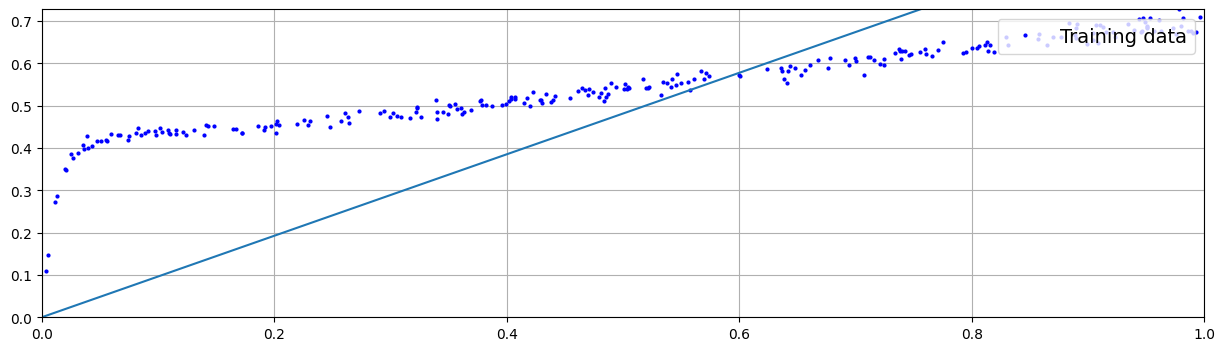

Model:
           6             5             4             3             2
1.697e-07 x - 4.585e-07 x + 4.851e-07 x - 2.511e-07 x + 6.971e-08 x + 0.9625 x
Coeffs Softmax:
[0.11470154 0.11470146 0.11470157 0.11470149 0.11470152 0.3117909
 0.11470152]
Coeffs:
[ 1.69695831e-07 -4.58504132e-07  4.85066238e-07 -2.51084856e-07
  6.97052158e-08  9.62501312e-01  0.00000000e+00]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 0.04707531866177464
R2:    -32.839499919652305


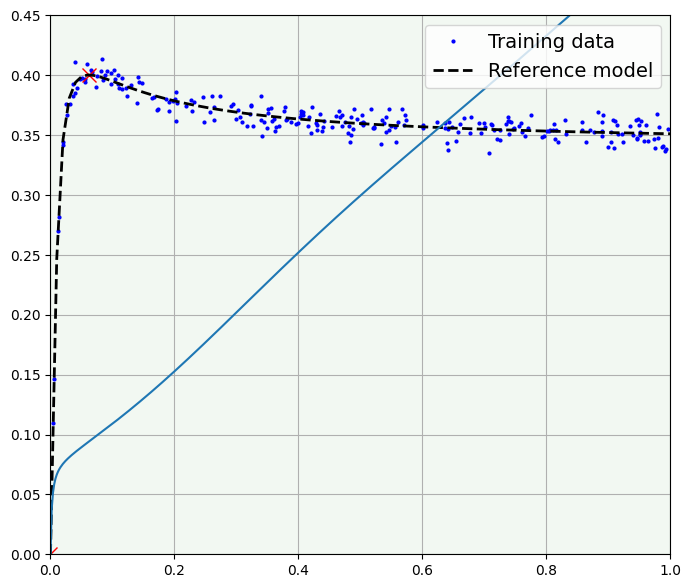



--- Pull from B(x) ---


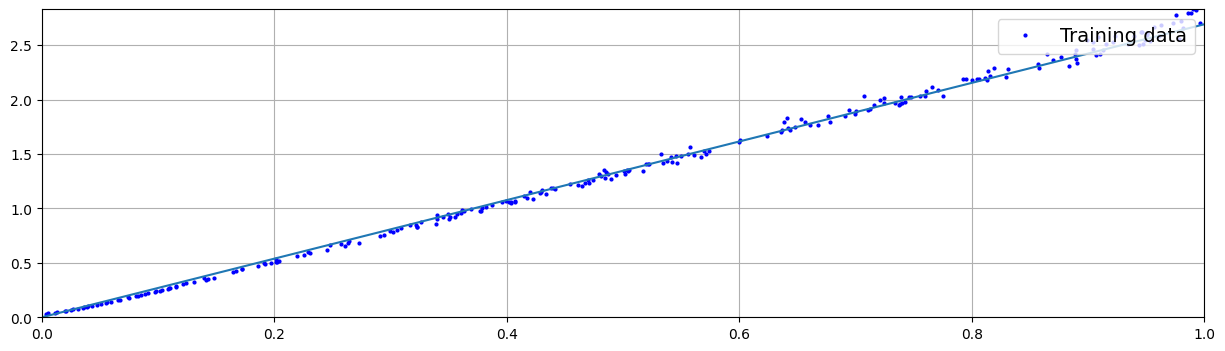

Model:
            6             5             4             3             2
-1.268e-05 x + 3.206e-05 x - 3.193e-05 x + 1.579e-05 x - 4.166e-06 x + 2.691 x + 8.462e-10
Coeffs Softmax:
[0.11470139 0.11470329 0.11470057 0.1147026  0.11470175 0.31178847
 0.11470193]
Coeffs:
[-1.26835693e-05  3.20573627e-05 -3.19280493e-05  1.57887465e-05
 -4.16640819e-06  2.69097261e+00  8.46170799e-10]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 1.7554665158716997e-05
R2:    -0.026349613180183695


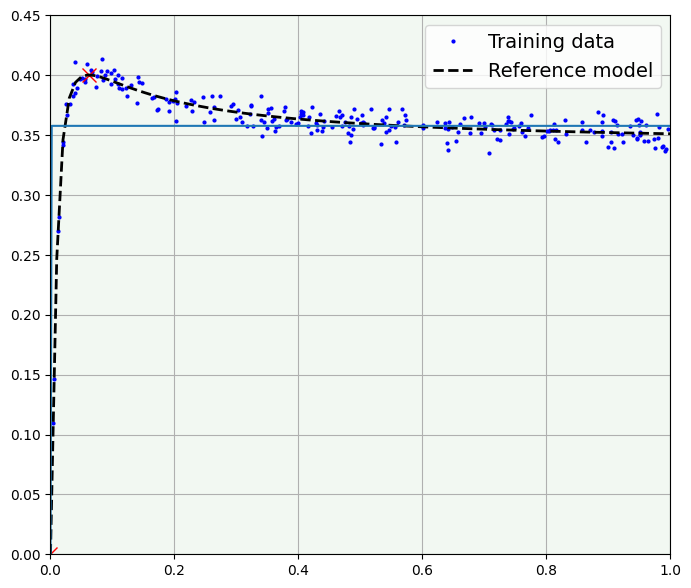



--- Pull from A(x) ---


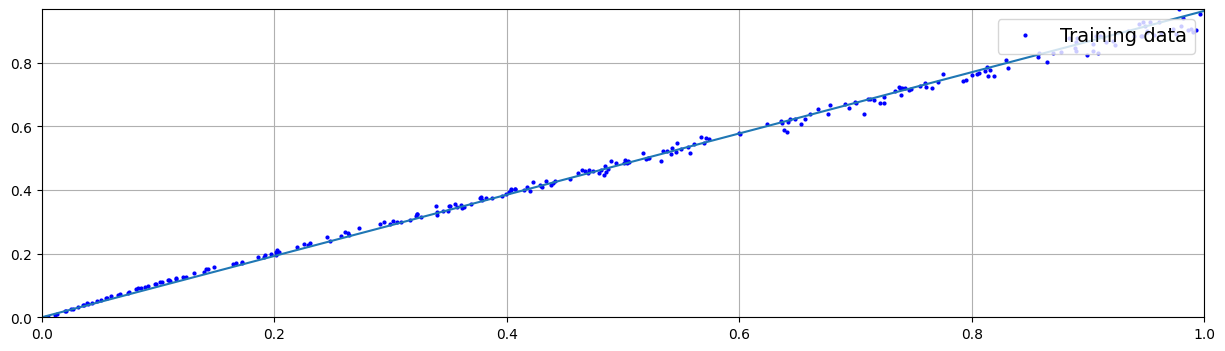

Model:
           6             5             4             3             2
1.744e-06 x - 4.862e-06 x + 5.364e-06 x - 2.898e-06 x + 8.805e-07 x + 0.963 x
Coeffs Softmax:
[0.11470188 0.1147011  0.11470232 0.11470133 0.11470178 0.31178991
 0.11470168]
Coeffs:
[ 1.74415317e-06 -4.86193744e-06  5.36426253e-06 -2.89799576e-06
  8.80454870e-07  9.63000785e-01  0.00000000e+00]

--- Pulled Eq/Ineq Constraints ---
A(0.06182000) = 0.06657563710455157

--- Final Model ---
K-MSE: 1.7401733905632354e-05
R2:    -0.024218579928054762


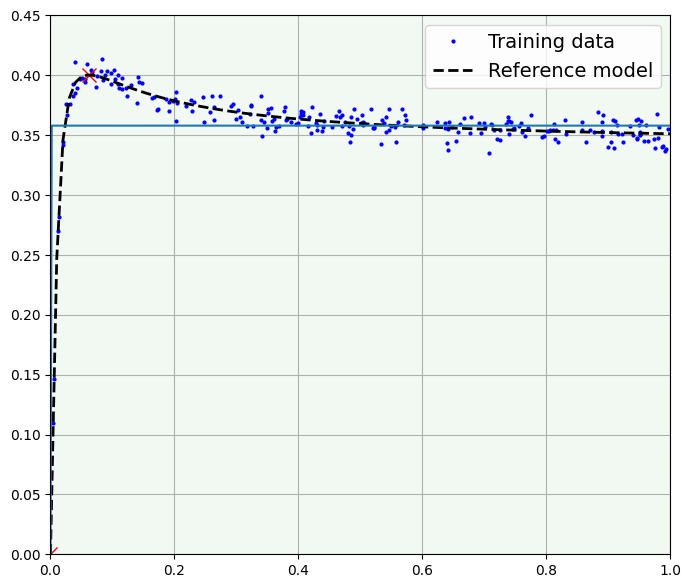



--- Pull from B(x) ---


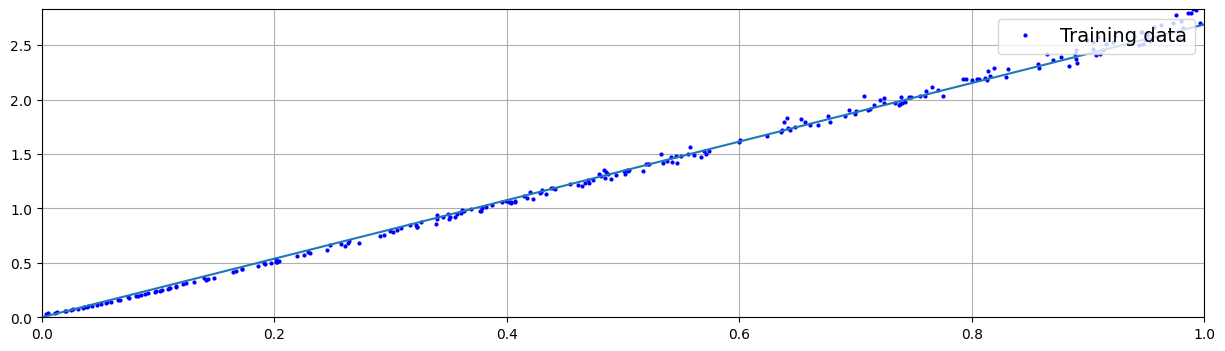

Model:
           6             5             4             3             2
-9.48e-05 x + 0.0002234 x - 0.0002046 x + 9.019e-05 x - 2.107e-05 x + 2.691 x + 7.333e-09
Coeffs Softmax:
[0.11470021 0.11471378 0.11469553 0.1147081  0.11470335 0.31177478
 0.11470425]
Coeffs:
[-9.48045573e-05  2.23438248e-04 -2.04576747e-04  9.01902252e-05
 -2.10662753e-05  2.69059362e+00  7.33295225e-09]

--- Pulled Eq/Ineq Constraints ---
B(0.06182000) = 0.148757399595425

--- Final Model ---
K-MSE: 1.7360252488858505e-05
R2:    -0.02365330603072069


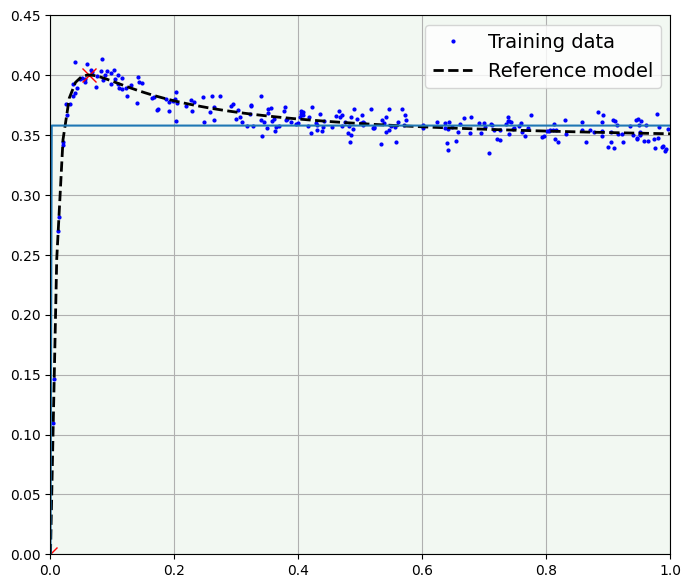

In [6]:
#
# show history (first Answer Set only).
#

constrmap = constraints.ConstraintMap()

for hist_entry in hist_set[0].entries:
    print(f"\n--- {hist_entry.msg} ---")
    
    if len(hist_entry.pulled_S.data) > 0:
        #y_scaled = utils.scale_y([dp.y for dp in hist_entry.pulled_S.data])
        #for i, dp in enumerate(hist_entry.pulled_S.data):
        #    dp.y = y_scaled[i]
        hist_entry.pulled_S.plot(width=15, height=4, plotref=False)
        xp = np.linspace(hist_entry.pulled_S.xl, hist_entry.pulled_S.xu, 500)
        plt.plot(xp, hist_entry.fit_model(xp));
        #plt.xlim(S.xl, S.xu)
        #plt.ylim(S.yl, S.yu)

        plt.show()
        #model, _ = utils.simplify_poly(hist_entry.fit_model, None)
        model = hist_entry.fit_model
        print(f"Model:\n{model}")
        print(f"Coeffs Softmax:\n{utils.coeffs_softmax(model.c)}")
        print(f"Coeffs:\n{model.c}")

    print("\n--- Pulled Eq/Ineq Constraints ---")
    for derivdeg in hist_entry.pulled_constrs.keys():
        for (dp, relopt) in hist_entry.pulled_constrs[derivdeg].eq_ineq:
            dp_x_str = "{:.8f}".format(dp.x)
            dp_y_str = str(dp.y) #"{:.8f}".format(dp.y)
            prime_sign = "'" * derivdeg
            constrmap.add(hist_entry.model_name + prime_sign, dp.x, dp.y, relopt)
            print(f"{hist_entry.model_name}{prime_sign}({dp_x_str}) {relopt.opt} {dp_y_str}")
    
    if len(hist_entry.violated_constrs) > 0:
        print("\n--- Violated Constraints ---")
        for (dp, relopt) in hist_entry.violated_constrs:
            dp_x_str = "{:.2f}".format(dp.x)
            dp_y_str = "{:.2f}".format(dp.y)
            print(f"m({dp_x_str}) {relopt.opt} {dp_y_str}")

    print("\n--- Final Model ---") 
    stree.set_unknown_model(hist_entry.model_name, hist_entry.fit_model)
    _, r2, k_mse = S.evaluate(stree.compute_output)
    print(f"K-MSE: {k_mse}")
    print(f"R2:    {r2}")
    
    S.plot(width=8, height=7)
    xp = np.linspace(S.xl, S.xu, 500)
    plt.plot(xp, stree.compute_output(xp));
    plt.show()

    print()